In [18]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [5]:
model_last1 = load_model('last_layer_trained_model.h5')
model_last2 = load_model('last_2_layers_trained_model.h5')
model_full = load_model('full_trained_model.h5')
model_removed = load_model('full_trained_model_removed_layers.h5')
model_1 = load_model('classifiaction_layer_trained_model')

In [79]:
model_1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [7]:
train_dir = "kaggle_bee_vs_wasp/"
resize_size = 224
bees_vs_wasps_dataset_path=Path(train_dir)

In [8]:
training_subsample = 1
#insect_class = {'bee': 0,'wasp': 1, 'insect': 2,'other': 3} 

df_labels = pd.read_csv(bees_vs_wasps_dataset_path/'labels.csv')
df_labels = df_labels.set_index('id')
df_labels = df_labels.sample(frac=training_subsample, axis=0)
df_labels = df_labels[['path','label']]
df_labels = df_labels.reset_index(drop=True)
df_labels

,path,label
0,bee1\248586134_69b2b01895_n.jpg,bee
1,wasp1\54872916_7654a3a1fe_n.jpg,wasp
2,bee1\14111443672_b99f6d071d_m.jpg,bee
3,wasp2\H00011.jpg,wasp
4,bee1\29122444355_cf71da02e1_n.jpg,bee
...,...,...
11416,other_insect\41751355012_a2bba9a646_n.jpg,insect
11417,wasp2\J00003.jpg,wasp
11418,wasp2\I00229.jpg,wasp
11419,wasp1\4875366098_4e46e2db8e_n.jpg,wasp


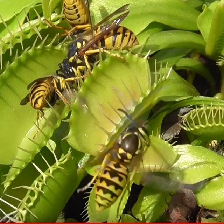

In [9]:
image_path = df_labels.sample()
image_path = image_path.path
image_path = image_path.replace('\\','/')
image = load_img(train_dir + image_path.values[0], target_size=(resize_size, resize_size))
image

In [10]:
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
predictions = model_full.predict(image)

print(predictions)
predicted_class = np.argmax(predictions)
predicted_class

[[0. 0. 0. 1.]]


3

In [12]:
######################################################################

In [11]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [30]:
model_builder = keras.applications.xception.Xception
img_size = (224, 224)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

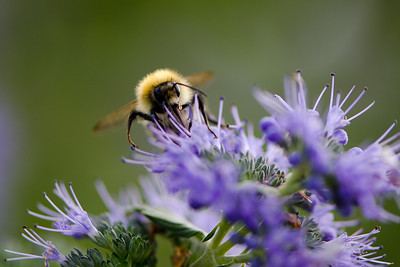

In [84]:
image_path = df_labels.sample()
image_path = image_path.path
image_path = image_path.replace('\\','/')
img_path = train_dir + image_path.values[0]
display(Image(img_path))

## Last layer trained 

In [85]:
last_conv_layer_name_last1 = "block5_conv3"
classifier_layer_names_last1 = ["block5_pool", "flatten", "fc1", "fc2", "output"]

[[9.2682761e-01 1.5677122e-02 1.1992232e-04 5.7375386e-02]]


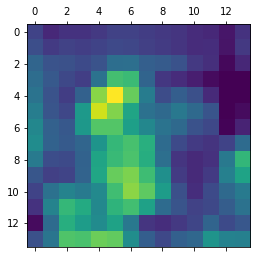

In [86]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))
preds = model_last1.predict(img_array)
print(preds)
heatmap = make_gradcam_heatmap(
    img_array, model_last1, last_conv_layer_name_last1, classifier_layer_names_last1
)
plt.matshow(heatmap)
plt.show()

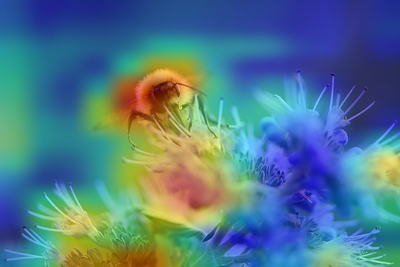

In [87]:
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)
heatmap = np.uint8(255 * heatmap)
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
superimposed_img = jet_heatmap + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
superimposed_img

## Last 2 layers trained 

In [88]:
last_conv_layer_name_last2 = "block5_conv3"
classifier_layer_names_last2 = ["block5_pool", "flatten", "fc1", "fc2", "output"]

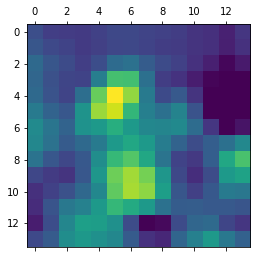

In [89]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))
preds = model_last2.predict(img_array)
heatmap = make_gradcam_heatmap(
    img_array, model_last2, last_conv_layer_name_last2, classifier_layer_names_last2
)
plt.matshow(heatmap)
plt.show()

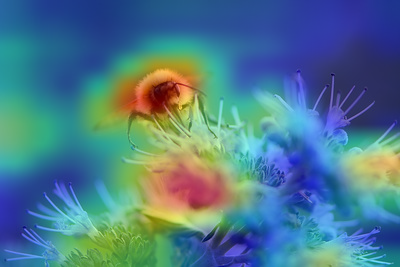

In [90]:
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)
heatmap = np.uint8(255 * heatmap)
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
superimposed_img = jet_heatmap + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
superimposed_img

## Full trained model 

In [91]:
last_conv_layer_name_full = "block5_conv3"
classifier_layer_names_full = ["block5_pool", "flatten", "fc1", "fc2", "output"]

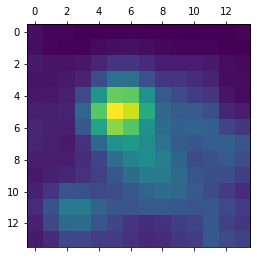

In [92]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))
preds = model_full.predict(img_array)
heatmap = make_gradcam_heatmap(
    img_array, model_full, last_conv_layer_name_full, classifier_layer_names_full
)
plt.matshow(heatmap)
plt.show()

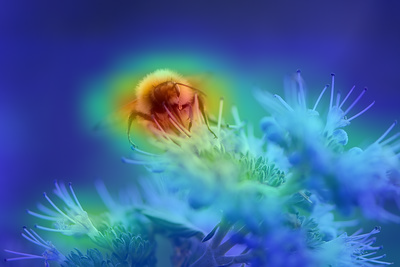

In [93]:
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)
heatmap = np.uint8(255 * heatmap)
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
superimposed_img = jet_heatmap + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
superimposed_img

## Full trained model removed layers

In [94]:
last_conv_layer_name_removed = "block4_conv3"
classifier_layer_names_removed = ["block4_pool", "flatten", "fc1", "fc2", "output"]

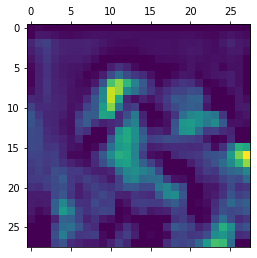

In [95]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))
preds = model_removed.predict(img_array)
heatmap = make_gradcam_heatmap(
    img_array, model_removed, last_conv_layer_name_removed, classifier_layer_names_removed
)
plt.matshow(heatmap)
plt.show()

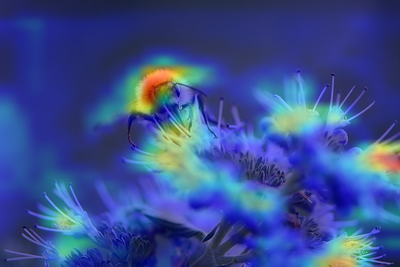

In [96]:
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)
heatmap = np.uint8(255 * heatmap)
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
superimposed_img = jet_heatmap + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
superimposed_img

## Only classificator trained 

In [97]:
last_conv_layer_name_1 = "block5_conv3"
classifier_layer_names_1 = ["block5_pool", "flatten", "fc1", "fc2", "output"]

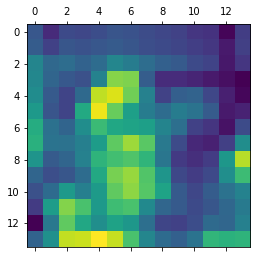

In [98]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))
preds = model_1.predict(img_array)
heatmap = make_gradcam_heatmap(
    img_array, model_1, last_conv_layer_name_1, classifier_layer_names_1
)
plt.matshow(heatmap)
plt.show()

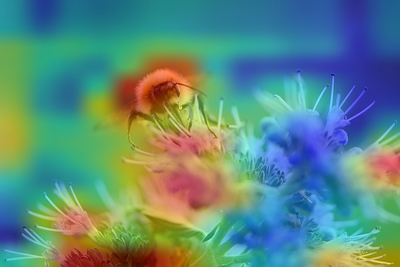

In [99]:
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)
heatmap = np.uint8(255 * heatmap)
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
superimposed_img = jet_heatmap + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
superimposed_img